Test plateforme de force labo asymétrie du pas

In [1]:
from pyCGM2.Tools import btkTools
from pyCGM2.ForcePlates import forceplates

from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz


DataPath = 'C:\\Users\\Nathan\\Desktop\\Wheelchair tests datas\\grf\\'
Path = DataPath + 'test_grf01.c3d'

acq = btkTools.smartReader(Path)
grwc = btkTools.getForcePlateWrench(acq)
mass = 60 # en kg

2023-05-12 15:55:54,623 - [ERROR] - pyCGM2 - (__init__.py).<module>(63) - EMG_CHANNELS is empty 


Détecte les différents paramètres sur les courbes de réaction vertical et ant-post depuis un C3D des plateformes de force

Pas numéro 0


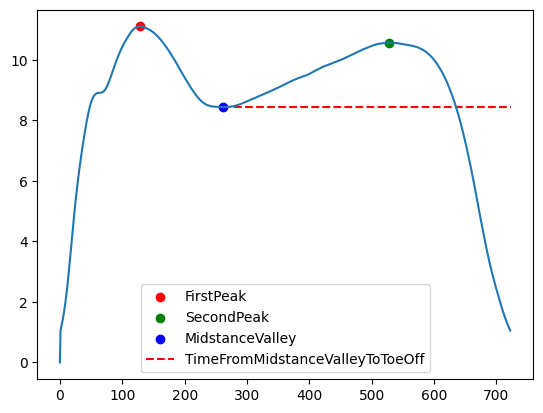

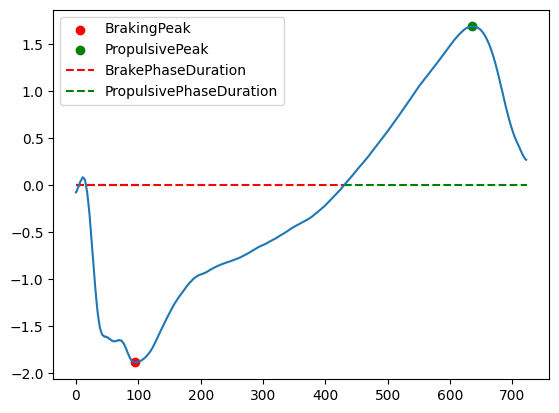

In [2]:
DataPath = 'C:\\Users\\Nathan\\Desktop\\Wheelchair tests datas\\grf\\'
Path = DataPath + 'test_grf01.c3d'

acq = btkTools.smartReader(Path)
grwc = btkTools.getForcePlateWrench(acq)
mass = 60 # en kg

def RollingMean(data, Step = 10):
    filtered = [value for value in data]
    filtered = pd.DataFrame(filtered)
    filtered = filtered.rolling(window = Step, center = True).mean()
    filtered = filtered.fillna(0)
    filtered = filtered[0].tolist()
    return np.array(filtered)

def SetZeroVertical(filtered):
    for index in np.arange(len(filtered)):
        if filtered[index] < 1:
            filtered[index] = 0
    return filtered

forces = dict()
plateformes = [0,1,2]

for plateforme in plateformes:
    data = grwc.GetItem(plateforme).GetForce().GetValues() / mass 
    filtered0 = RollingMean(data[:,0])
    filtered1 = RollingMean(data[:,1])
    filtered2 = SetZeroVertical(RollingMean(data[:,2]))
    forces[plateforme] = {"Ve" : np.abs(filtered2),
                          "Ap" : filtered1,
                          "Ml" : filtered0}    


dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = forces[1]["Ve"] #VerticalGrfLeft
dataLeft["ApGrf"] = forces[1]["Ap"]#ApGrfLeft
dataLeft["MediolateralGrf"] = forces[1]["Ml"] #MediolateralGrfLeft

SoleInstanceLeft = FeetMe(1000)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = forces[0]["Ve"] #VerticalGrfRight
dataRight["ApGrf"] = forces[0]["Ap"] #ApGrfRight
dataRight["MediolateralGrf"] = forces[0]["Ml"] #MediolateralGrfRight

SoleInstanceRight = FeetMe(1000)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)


from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import GroundReactionForceKinematicsProcedure

procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()


from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()

#du coup je relance les calculs des valeurs sur les donnés normalisés
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

for stepindex in np.arange(len(walking.m_StepGrfValue['LeftLeg']['VerticalGrf'])) : # plot tout les pas avec les data trouvés
    """ Visualisation des valeurs retrouvées par GroundReactionForceKinematicsProcedure() """
    FrameRate = 10
    step = stepindex
    print(f"Pas numéro {step}")

    """ Vertical Ground Reaction Force Data """ 

    FirstPeak = walking.m_GroundReactionForces["LeftLeg"][step][0]
    MidstanceValley = walking.m_GroundReactionForces["LeftLeg"][step][1]
    SecondPeak = walking.m_GroundReactionForces["LeftLeg"][step][2]
    FirtPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][3] * FrameRate
    MidstanceValleyTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][4] * FrameRate
    SecondPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][5] * FrameRate
    TimeFromMidstanceValleyToToeOff = walking.m_GroundReactionForces["LeftLeg"][step][6] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['VerticalGrf'][step])
    plt.scatter(x=FirtPeakTimeTo ,y=FirstPeak, c ="r", label="FirstPeak")
    plt.scatter(x=SecondPeakTimeTo ,y=SecondPeak, c="g", label="SecondPeak")
    plt.scatter(x=MidstanceValleyTimeTo ,y=MidstanceValley, c="b", label="MidstanceValley")
    plt.hlines(y=MidstanceValley, xmin=MidstanceValleyTimeTo, xmax=TimeFromMidstanceValleyToToeOff+MidstanceValleyTimeTo,
            colors ="r", ls="--", label='TimeFromMidstanceValleyToToeOff')
    plt.legend()
    plt.show()


    """ Ant-Post Ground Reaction Force Data """
    BrakingPeak = walking.m_GroundReactionForces["LeftLeg"][step][10]
    PropulsivePeak = walking.m_GroundReactionForces["LeftLeg"][step][11]
    BrakePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][12] * FrameRate
    PropulsivePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][13] * FrameRate
    BrakePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][14] * FrameRate
    PropulsivePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][15] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['ApGrf'][step])
    plt.scatter(x= BrakePhaseTimeTo, y=BrakingPeak, c="r", label='BrakingPeak')
    plt.scatter(x= PropulsivePhaseTimeTo + BrakePhaseDuration, y=PropulsivePeak, c="g", label='PropulsivePeak')
    plt.hlines(y=0, xmin=0, xmax=102, colors ="black", ls="--")
    plt.hlines(y=0, xmin=0, xmax=BrakePhaseDuration, colors ="r", ls="--", label='BrakePhaseDuration')
    plt.hlines(y=0, xmin=BrakePhaseDuration, xmax=BrakePhaseDuration + PropulsivePhaseDuration, colors ="g", ls="--", label='PropulsivePhaseDuration')
    plt.legend()
    plt.show()

Test normaliser en %BM

113.19726703525845

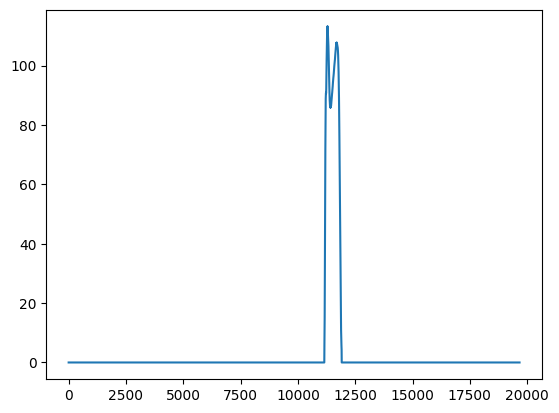

In [11]:
DataPath = 'C:\\Users\\Nathan\\Desktop\\Wheelchair tests datas\\grf\\'
Path = DataPath + 'test_grf01.c3d'

acq = btkTools.smartReader(Path)
grwc = btkTools.getForcePlateWrench(acq)
mass = 60 # en kg

grf = grwc.GetItem(1).GetForce().GetValues() / (mass * 9.81) * 100

VerticalGrf = grf[:,2]

plt.plot(VerticalGrf)
VerticalGrf.max()

Représenter la fonction de symétrie dynamique entre droit et gauche avec un C3D des plateforme de force

GroundReactionForceKinematicsProcedure : done
NormalisationProcedure : done


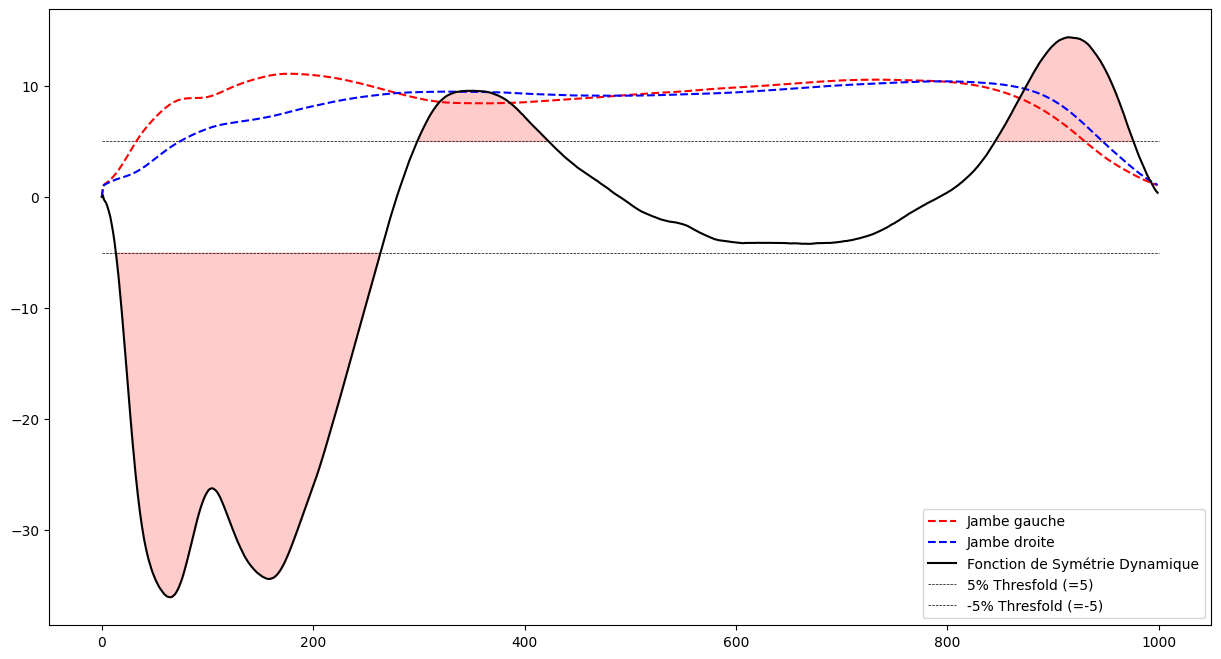

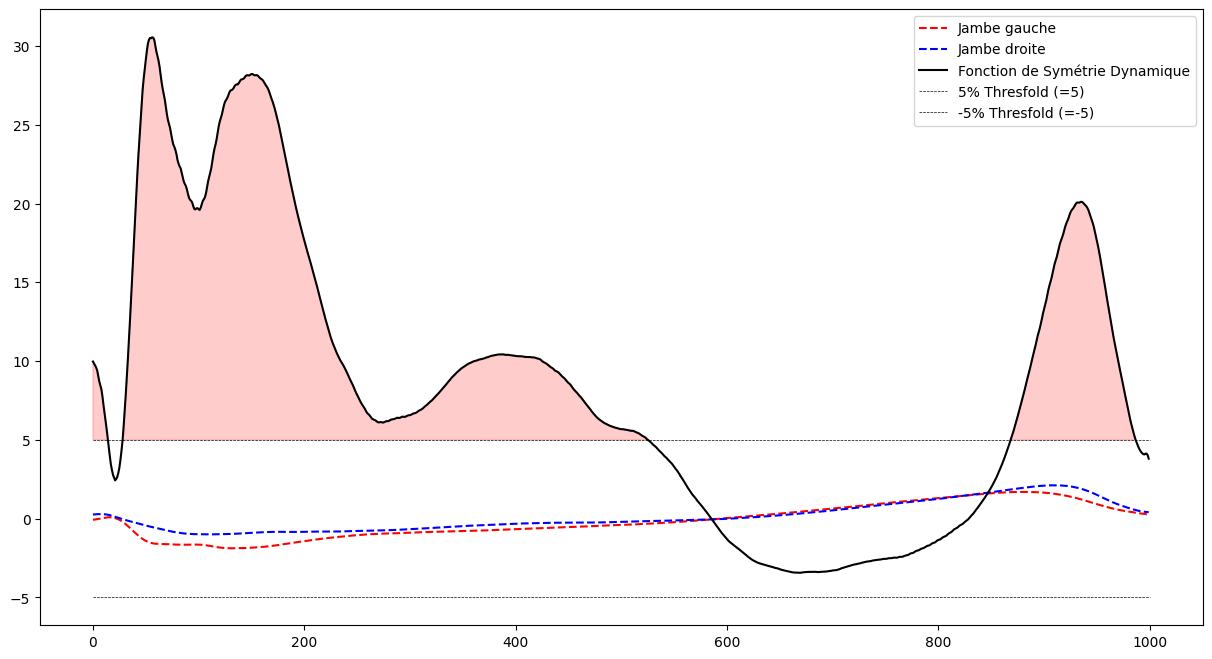

In [12]:
from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotDynamicSymetryFunctionNormalisedProcedure

procedure = PlotDynamicSymetryFunctionNormalisedProcedure()
WalkingGraphicsFilter(walking, procedure).run()